In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.image import imread

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, regularizers, models, optimizers, losses

from tensorflow.keras.applications import MobileNetV2, InceptionResNetV2
import tensorflow_hub as hub

In [167]:
# read in csv file containing file names and breeds
breed_df = pd.read_csv('data/dog-breed-identification/labels.csv')

In [168]:
breed_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [36]:
# both columns are object type
breed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [37]:
# number of images per breed range from 66-126
breed_df['breed'].value_counts() 

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [178]:
# get the directory for the training images
train_dir = 'data/dog-breed-identification/train/'

In [179]:
# add directory path and .jpg to each image name in dataframe  to make readable
breed_df['id'] = train_dir+breed_df['id']+'.jpg'

### Get the top 10 breeds and visualize a sample set of images

In [40]:
# get top 10 dog breeds
top_10 = breed_df['breed'].value_counts()[:10]
top_10

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: breed, dtype: int64

In [41]:
# get the top 10 dog breeds for visualization
top_breed_images = []

for breed in top_10.index:
    breed_img = breed_df[breed_df['breed'] == breed].iloc[np.random.randint(len(breed_df[breed_df['breed'] == breed]))]
    top_breed_images.append(breed_img)

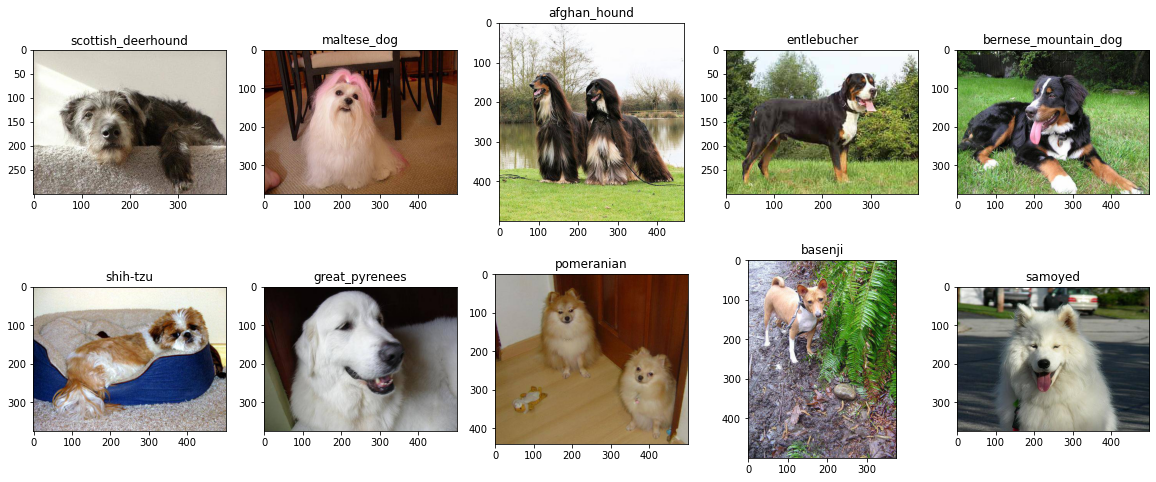

In [42]:
# visualize example images of the top 10 dog breeds
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))

x = 0
for i in range(2):
    for j in range(5):
        im = plt.imread(top_breed_images[x]['id'])
        axes[i][j].imshow(im)
        axes[i][j].plot()
        axes[i][j].set_title(top_breed_images[x]['breed'])
        x += 1

### Split data frame into train and validation and use image data generator to create augmented images for modeling

In [111]:
train_df, val = train_test_split(breed_df, test_size=0.25, random_state=42)

In [123]:
val_df, test_df = train_test_split(val, test_size=0.10, random_state=42, stratify=val['breed'])

In [124]:
# use data augmentation on train split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_data = train_datagen.flow_from_dataframe( 
    train_df,
    x_col='id',
    y_col='breed',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32)

# do not use data augmentation on validation split
val_datagen = ImageDataGenerator(rescale = 1./255)
val_data = val_datagen.flow_from_dataframe(val_df,
                                             x_col = 'id',
                                             y_col = 'breed',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_data = test_datagen.flow_from_dataframe(test_df,
                                             x_col = 'id',
                                             y_col = 'breed',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)


Found 7666 validated image filenames belonging to 120 classes.
Found 2300 validated image filenames belonging to 120 classes.
Found 256 validated image filenames belonging to 120 classes.


In [114]:
breed_classes = train_data.class_indices

In [115]:
breed_classes

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [216]:
train_images, train_labels = next(train_data)
val_images, val_labels = next(val_data)
test_images, test_labels = next(test_data)

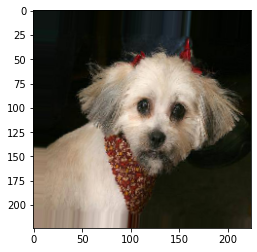

In [117]:
# show an example of how data augmentation affects images
plt.imshow(train_images[0])

# Modeling

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [19]:
# function plots the accuracy and loss of the train and val over epochs
def plot_model(results):
    
    history=results.history

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    ax1.plot(history['loss'], label='Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.grid(False)
    ax1.legend()

    ax2.plot(history['acc'], label = 'Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.grid(False)
    ax2.legend();

In [20]:
# function takes y_pred and y_true and plots confusion matrix
def plot_confusion_matrix(model, y_true, y_images):
    predictions = model.predict(y_images)
    y_pred = np.round(predictions, 0)
    y_pred = np.reshape(y_pred, -1)

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Pneumonia'])
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()
    
    print(classification_report(y_true, y_pred))

### Baseline Model: Tensorflow Pre-trained MobileNetV2 model
Using MobileNetV2 because it is the most efficient model to use in a mobile app. This is becasue it is faster and smaller than other models. It can be known to sacrifice some accuracy, though I tried other models and MobileNetV2 was the most accurate on this data. 

In [30]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
baseline_model = models.Sequential()

baseline_model.add(mobilenet)
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(120, activation='softmax'))

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [32]:
baseline_results = baseline_model.fit(train_data, 
                                      validation_data = val_data, 
                                      epochs = 10, 
                                      callbacks=[early_stopping])

Epoch 1/10
256/256 [==============================] - 185s 722ms/step - loss: 14.3137 - acc: 0.4403 - val_loss: 14.9228 - val_acc: 0.5462
Epoch 2/10
256/256 [==============================] - 194s 757ms/step - loss: 9.3761 - acc: 0.6577 - val_loss: 13.4779 - val_acc: 0.6068
Epoch 3/10
256/256 [==============================] - 189s 738ms/step - loss: 7.7934 - acc: 0.7307 - val_loss: 15.9760 - val_acc: 0.5995
Epoch 4/10
256/256 [==============================] - 193s 753ms/step - loss: 5.9297 - acc: 0.7889 - val_loss: 16.4295 - val_acc: 0.6381
Epoch 5/10
256/256 [==============================] - 189s 736ms/step - loss: 5.2617 - acc: 0.8103 - val_loss: 16.2986 - val_acc: 0.6430
Epoch 6/10
256/256 [==============================] - 184s 720ms/step - loss: 4.8734 - acc: 0.8359 - val_loss: 16.8523 - val_acc: 0.6504
Epoch 7/10
256/256 [==============================] - 194s 759ms/step - loss: 4.5200 - acc: 0.8495 - val_loss: 21.2607 - val_acc: 0.6386


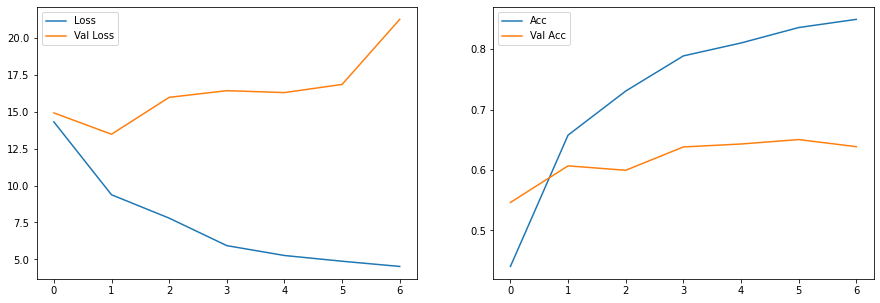

In [35]:
plot_model(baseline_results)

### Tuned MobileNetV2 model
We can see by our validation loss and accuracy that our model is clearly overfitting on our training data, so lets add some other layers and dropout to see if we can fix that

In [38]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
trained_model = models.Sequential()

trained_model.add(mobilenet)
trained_model.add(layers.GlobalAveragePooling2D())
trained_model.add(layers.Dense(512, activation = 'relu'))
trained_model.add(layers.Dropout(0.5))
trained_model.add(layers.Dense(120, activation='softmax'))

trained_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [39]:
trained_results = trained_model.fit(train_data, 
                             validation_data = val_data, 
                             epochs = 10, 
                             callbacks=[early_stopping])

Epoch 1/10
256/256 [==============================] - 179s 701ms/step - loss: 2.5753 - acc: 0.3764 - val_loss: 1.1690 - val_acc: 0.6738
Epoch 2/10
256/256 [==============================] - 181s 706ms/step - loss: 1.4541 - acc: 0.5904 - val_loss: 1.0375 - val_acc: 0.6900
Epoch 3/10
256/256 [==============================] - 182s 710ms/step - loss: 1.2351 - acc: 0.6402 - val_loss: 1.0003 - val_acc: 0.7046
Epoch 4/10
256/256 [==============================] - 183s 717ms/step - loss: 1.1284 - acc: 0.6614 - val_loss: 1.0079 - val_acc: 0.6954
Epoch 5/10
256/256 [==============================] - 189s 736ms/step - loss: 1.0362 - acc: 0.6900 - val_loss: 0.9894 - val_acc: 0.7051
Epoch 6/10
256/256 [==============================] - 182s 712ms/step - loss: 1.0113 - acc: 0.6965 - val_loss: 0.9795 - val_acc: 0.7056
Epoch 7/10
256/256 [==============================] - 190s 744ms/step - loss: 0.9293 - acc: 0.7201 - val_loss: 0.9887 - val_acc: 0.7081
Epoch 8/10
256/256 [============================

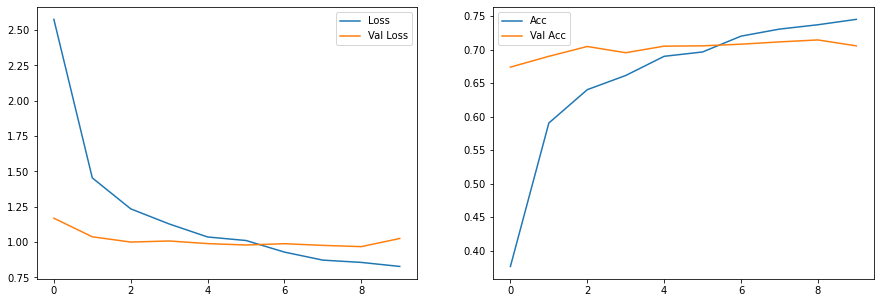

In [40]:
plot_model(trained_results)

In [41]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
trained_model2 = models.Sequential()

trained_model2.add(mobilenet)
trained_model2.add(layers.GlobalAveragePooling2D())
trained_model2.add(layers.Dense(512, activation = 'relu'))
trained_model2.add(layers.BatchNormalization())
trained_model2.add(layers.Dropout(0.5))
trained_model2.add(layers.Dense(120, activation='softmax'))

trained_model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [42]:
trained_results2 = trained_model2.fit(train_data, 
                             validation_data = val_data, 
                             epochs = 10, 
                             callbacks=[early_stopping])

Epoch 1/10
256/256 [==============================] - 188s 734ms/step - loss: 2.2619 - acc: 0.4554 - val_loss: 1.1733 - val_acc: 0.6685
Epoch 2/10
256/256 [==============================] - 186s 725ms/step - loss: 1.2641 - acc: 0.6417 - val_loss: 1.0295 - val_acc: 0.6905
Epoch 3/10
256/256 [==============================] - 187s 730ms/step - loss: 1.0584 - acc: 0.6870 - val_loss: 1.0536 - val_acc: 0.6993
Epoch 4/10
256/256 [==============================] - 187s 731ms/step - loss: 0.9313 - acc: 0.7263 - val_loss: 1.0260 - val_acc: 0.7022
Epoch 5/10
256/256 [==============================] - 186s 725ms/step - loss: 0.8661 - acc: 0.7376 - val_loss: 0.9987 - val_acc: 0.7134
Epoch 6/10
256/256 [==============================] - 3212s 13s/step - loss: 0.8241 - acc: 0.7486 - val_loss: 0.9961 - val_acc: 0.7208
Epoch 7/10
256/256 [==============================] - 178s 695ms/step - loss: 0.7320 - acc: 0.7742 - val_loss: 1.0296 - val_acc: 0.7046
Epoch 8/10
256/256 [=============================

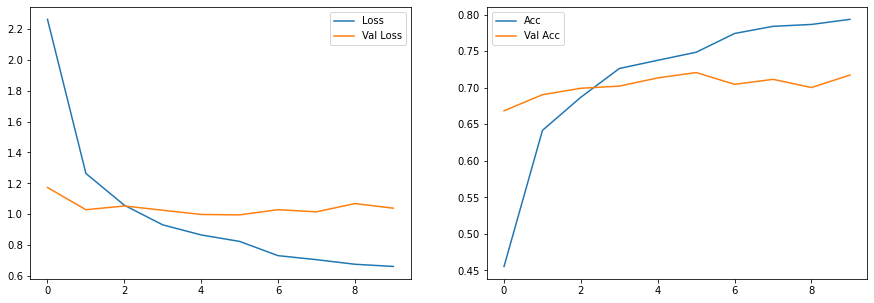

In [43]:
plot_model(trained_results2)

#### We have significantly reduced our loss and we have improved accuracy but we are still seeing overfitting. Lets use the tensorflow hub version of MobileNetV2 to see if we can improve accuracy more and reduce overfitting

### Tensorflow Hub MobileNet V2 

In [80]:
mobilenet_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4")

mobilenet_hub = models.Sequential([mobilenet_model, 
                          layers.Dense(units=120, activation="softmax")])

mobilenet_hub.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics = ['acc'])


In [81]:
hub_results = mobilenet_hub.fit(train_data,
                        epochs=10,
                        validation_data=val_data,
                        validation_freq=1, 
                        callbacks=early_stopping)

Epoch 1/10
256/256 [==============================] - 218s 850ms/step - loss: 1.7871 - acc: 0.5695 - val_loss: 0.8328 - val_acc: 0.7594
Epoch 2/10
256/256 [==============================] - 206s 803ms/step - loss: 0.7074 - acc: 0.7862 - val_loss: 0.7527 - val_acc: 0.7804
Epoch 3/10
256/256 [==============================] - 207s 809ms/step - loss: 0.5396 - acc: 0.8282 - val_loss: 0.7671 - val_acc: 0.7814
Epoch 4/10
256/256 [==============================] - 207s 809ms/step - loss: 0.4410 - acc: 0.8600 - val_loss: 0.7656 - val_acc: 0.7751
Epoch 5/10
256/256 [==============================] - 211s 825ms/step - loss: 0.3771 - acc: 0.8773 - val_loss: 0.7804 - val_acc: 0.7834
Epoch 6/10
256/256 [==============================] - 208s 813ms/step - loss: 0.3268 - acc: 0.8956 - val_loss: 0.7872 - val_acc: 0.7868
Epoch 7/10
256/256 [==============================] - 209s 817ms/step - loss: 0.2996 - acc: 0.9019 - val_loss: 0.8267 - val_acc: 0.7873


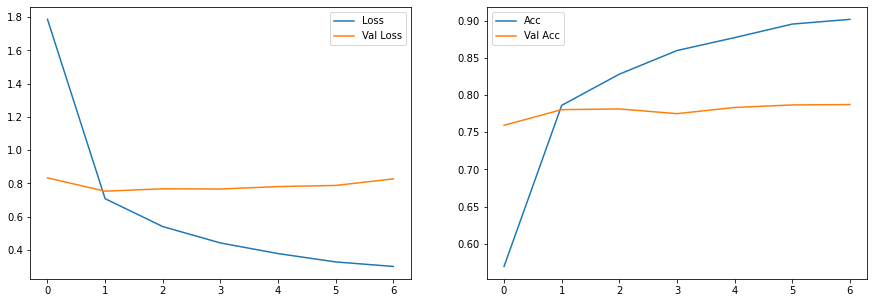

In [98]:
plot_model(hub_results)

In [118]:
mobilenet_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4")

mobilenet_hub2 = models.Sequential([mobilenet_model, 
                          layers.Dense(units=120, activation="softmax")])

mobilenet_hub2.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics = ['acc'])


In [119]:
hub_results2 = mobilenet_hub2.fit(train_data,
                        epochs=10,
                        validation_data=val_data,
                        validation_freq=1, 
                        callbacks=early_stopping)

Epoch 1/10
240/240 [==============================] - 208s 867ms/step - loss: 1.8716 - acc: 0.5522 - val_loss: 0.8634 - val_acc: 0.7535
Epoch 2/10
240/240 [==============================] - 216s 901ms/step - loss: 0.7126 - acc: 0.7863 - val_loss: 0.7922 - val_acc: 0.7730
Epoch 3/10
240/240 [==============================] - 205s 854ms/step - loss: 0.5357 - acc: 0.8349 - val_loss: 0.7737 - val_acc: 0.7652
Epoch 4/10
240/240 [==============================] - 206s 857ms/step - loss: 0.4419 - acc: 0.8574 - val_loss: 0.7780 - val_acc: 0.7696
Epoch 5/10
240/240 [==============================] - 206s 856ms/step - loss: 0.3686 - acc: 0.8779 - val_loss: 0.7872 - val_acc: 0.7735
Epoch 6/10
240/240 [==============================] - 207s 862ms/step - loss: 0.3216 - acc: 0.8992 - val_loss: 0.7982 - val_acc: 0.7709
Epoch 7/10
240/240 [==============================] - 215s 897ms/step - loss: 0.2805 - acc: 0.9088 - val_loss: 0.8186 - val_acc: 0.7709
Epoch 8/10
240/240 [============================

In [125]:
test_eval = mobilenet_hub2.evaluate(test_data)

8/8 [==============================] - 4s 514ms/step - loss: 0.9420 - acc: 0.7812


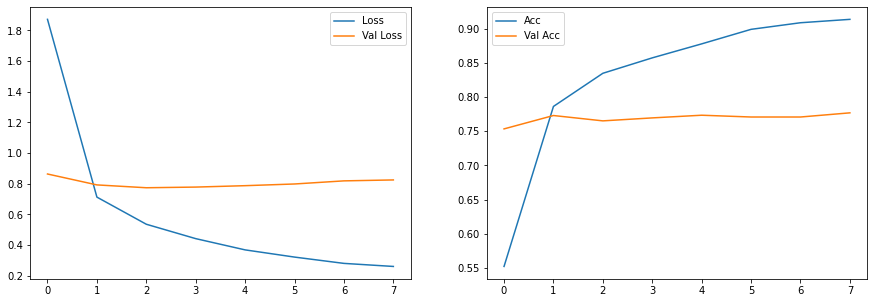

In [138]:
plot_model(hub_results2)

In [217]:
plot_confusion_matrix(mobilenet_hub2, test_labels, test_images)

ValueError: Found input variables with inconsistent numbers of samples: [32, 3840]

#### MobileNetV2 Hub gave us the best results. We will consider this to be our final model and save it to be used in our mobile app. Let's test it out on some test images to see how well it performs.

In [ ]:
# save model
# mobilenet_hub.save('data/models/mobilenet_hub.h5')

In [ ]:
saved_augment = tf.keras.models.load_model('data/models/augment_model.h5')

In [ ]:
# with open('data/models/augment_history', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

## InceptionResNetV2
Test out another pre-trained model to see how it's performance compares to MobileNetV2

In [60]:
inception = InceptionResNetV2(include_top = False, weights ='imagenet', input_shape = (224,224,3))
inception.trainable = False

inception_model = models.Sequential()
inception_model.add(transfer_model)
inception_model.add(layers.GlobalAveragePooling2D())
inception_model.add(layers.Dense(512,activation='relu'))
inception_model.add(layers.Dropout(0.5))

inception_model.add(layers.Dense(120,activation = 'softmax'))

inception_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['acc'])

inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 9, 9, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               786944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 55,185,240
Trainable params: 848,504
Non-trainable params: 54,336,736
_________________________________________________________________


In [61]:
inception_report = inception_model.fit(train_data,
                    epochs = 5,
                    validation_data = val_data,
                    callbacks = early_stopping)

Epoch 1/5
256/256 [==============================] - 626s 2s/step - loss: 1.5652 - accuracy: 0.6528 - val_loss: 0.6614 - val_accuracy: 0.8108
Epoch 2/5
256/256 [==============================] - 630s 2s/step - loss: 0.9937 - accuracy: 0.7513 - val_loss: 0.6621 - val_accuracy: 0.8112
Epoch 3/5
256/256 [==============================] - 614s 2s/step - loss: 0.9300 - accuracy: 0.7585 - val_loss: 0.6715 - val_accuracy: 0.8064
Epoch 4/5
256/256 [==============================] - 604s 2s/step - loss: 0.8878 - accuracy: 0.7605 - val_loss: 0.6513 - val_accuracy: 0.8220
Epoch 5/5
256/256 [==============================] - 582s 2s/step - loss: 0.8639 - accuracy: 0.7678 - val_loss: 0.6626 - val_accuracy: 0.8166


KeyError: 'acc'

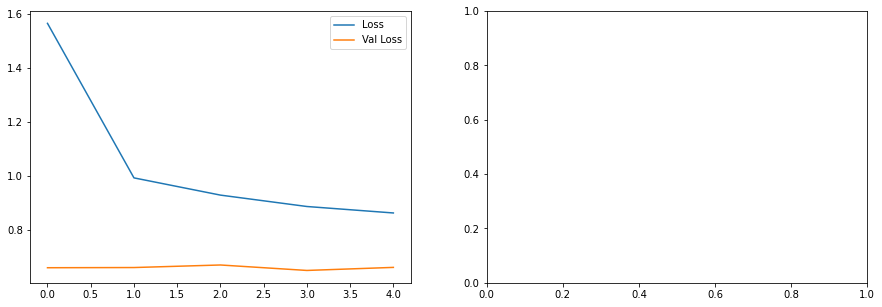

In [99]:
plot_model(inception_report)

#### Gives higher validation accuracy and lower validation loss, but performed worse on training accuracy and loss. Also when tested of sample images, correctly identified breeds at similar rate as MobileNetV2, but at much lower percentages. (MobileNetV2 would categorize breed at 91% and InceptionResNetV2 would categorize correctly but only at 23%). We will sick with MobileNetV2 as our final model because of it's relatively high accuract as well as it's speed. 

# Evaluation

In [211]:
# create a function that processes an input image into usable format for prediction
def predict_input(image_path, model, label='None'):
    # turn breed classes into a list
    
    if label == 'None' or label not in breed_classes:
        label == 'None'
    
    breeds = list(breed_classes)
        
    #plot image
    plt.figure()
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    
    #predict image
    photo = load_img(test_dog, target_size=(224, 224))
    photo = img_to_array(photo)/255
    reshape_image = np.reshape(photo, [1, photo.shape[0], photo.shape[1], 3])
    predictions = np.array(model.predict(reshape_image))
    predicted_class = np.argmax(predictions, -1)
    
    # plot prediction class and percentage
    plt.title(f"Breed Prediction: {np.max(predictions)*100:.1f}% {breeds[predicted_class[0]]}\n", fontsize=15)

    # get top 5 breed predictions
    top_preds = predictions[0].argsort()[-5:][::-1]
    top_breeds = []
    for n in top_preds:
        top_breeds.append([breeds[n], predictions[0][n]])
        
    # plot top 5 predictions and their percentages 
    color = ['green' if (x[0] == label) else 'grey' for x in top_breeds]
    
    plt.figure()
    plt.bar([n[0] for n in top_breeds], [m[1] for m in top_breeds], color=color)
    plt.xticks(rotation=45)
    
    
   # get the top 10 dog breeds for visualization
    fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15, 5))
    
    for x in range(len(top_breeds)):
        breed_img = breed_df[breed_df['breed'] == top_breeds[x][0]].iloc[0]
        image = plt.imread(breed_img['id'])
        ax[x].imshow(image)
        ax[x].axis('off')
        ax[x].set_title(top_breeds[x][0])
        
        
    return predictions

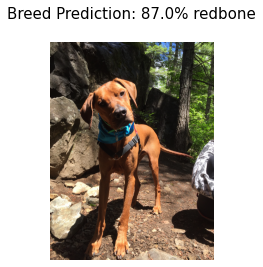

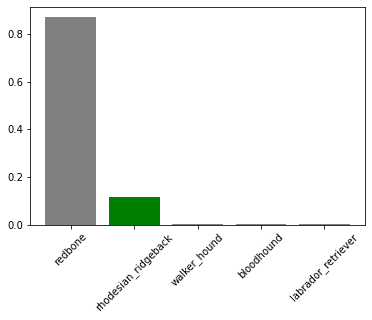

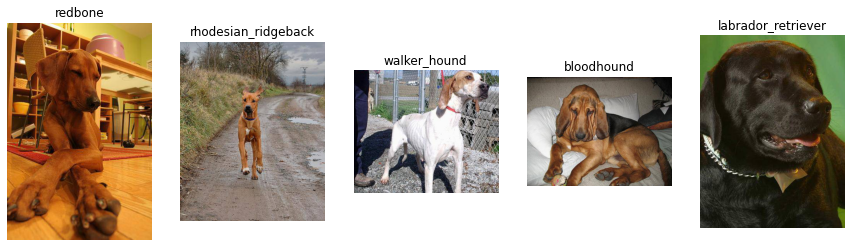

In [213]:
test_dog = 'data/test_huck/IMG_4463.jpg'
pred_dog = predict_input(test_dog, mobilenet_hub2, 'rhodesian_ridgeback')